<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/flow_matching_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install datasets
!pip install ipdb
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate
!pip install einops
!pip install torchdiffeq
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.

In [1]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
# import wandb
import time
import numpy

from pathlib import Path
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st

from datasets import load_dataset
from diffusers import UNet2DModel
from accelerate import Accelerator
from einops import rearrange

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2

from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

FMNIST_IN_CHANNELS = 1
FMNIST_OUT_CHANNELS = 1

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
def _pre_conv(ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni))
  layers.append(nn.Conv2d(ni, nf, kernel_size, stride = stride, padding = kernel_size//2, bias = True))
  return nn.Sequential(*layers)

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = None):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class FID:
  def __init__(self, model = None, targ = None):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

In [3]:
class SM:
  def forward(self, *args, **kwargs):
    self.saved = super().forward(*args, **kwargs)
    return self.saved

class SConv(SM, nn.Conv2d): pass
class SResBlock(SM, ResBlock): pass

class SelfAttention(nn.Module):
  def __init__(self, ni):
    super().__init__()
    self.kqv = nn.Linear(ni, 3*ni)
    self.norm = nn.GroupNorm(1, ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = ni

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      return rearrange(x, 'b c h w -> b (h w) c')
    if mode == 2:
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # Verify Shape
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return inp + x

class MultiHeadSelfAttentionV2(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # st()
    x = inp
    x = self.norm(x)

    h, w = x.shape[-2], x.shape[-1]

    x = rearrange(x, 'b c h w -> b (h w) c')
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    k = rearrange(k, 'b s (c d) -> (b d) s c', d = self.n_heads)
    q = rearrange(q, 'b s (c d) -> (b d) s c', d = self.n_heads)
    v = rearrange(v, 'b s (c d) -> (b d) s c', d = self.n_heads)

    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    att_x = rearrange(att_x, '(b d) s c -> b s (c d)', d = self.n_heads)
    x = self.proj(att_x)
    out = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
    return out

class AttEmbResBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.emb_proj = nn.Linear(n_emb, 2*nf)
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.conv1 = _pre_conv(ni, nf, kernel_size, 1, act, norm)
    self.conv2 = _pre_conv(nf, nf, kernel_size, stride, act, norm)
    if attn: self.attn = MultiHeadSelfAttentionV2(nf, 8)

  def forward(self, x, t_emb):
    res = self.conv1(x)
    t_emb = self.emb_proj(t_emb)[:, :, None, None]  # bs, 2*nf
    scale, shift = t_emb.chunk(2, dim = 1)
    res = res + res * scale + shift
    res = self.conv2(res)
    x = self.id_conv(x) + res
    if hasattr(self, 'attn'): x = x + self.attn(x)
    return x

class SAttEmbResBlock(SM, AttEmbResBlock): pass

class DownBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.layers = nn.ModuleList([SAttEmbResBlock(ni if i == 0 else nf, nf, n_emb = n_emb, act = act, norm = norm, attn = attn) for i in range(n_layers)])
    self.f_layer = SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1) if add_down == True else fc.noop

  def forward(self, x, t_emb):
    for layer in self.layers:
      x = layer(x, t_emb)
    return self.f_layer(x)

  def get_acts(self):
    acts = [l.saved for l in self.layers]
    if hasattr(self.f_layer, 'saved'): acts.append(self.f_layer.saved)
    return acts

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, n_emb, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(AttEmbResBlock(inc, nf, n_emb = n_emb, act = act, norm = norm, attn = attn))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups, t_emb):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1), t_emb)
    return self.up(x)

class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = FMNIST_IN_CHANNELS, out_channels = FMNIST_OUT_CHANNELS,
                                                    nfs = [64, 128, 256, 512], n_layers = 2, emb_dim = 16, attn_start = 2, n_classes = 10):
    super().__init__()
    self.emb_dim = emb_dim
    n_emb = nfs[0]*4
    self.emb_mlp = nn.Sequential(nn.Linear(emb_dim, n_emb, bias = True),
                                 nn.BatchNorm1d(n_emb),
                                 nn.Linear(n_emb, n_emb, bias = True))

    self.c_emb = nn.Embedding(n_classes, n_emb)

    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(DownBlock(ni, nf, n_emb = n_emb, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True, attn = True if i >= attn_start else False))
      ni = nf

    self.downs = nn.Sequential(*downs)

    cross = [AttEmbResBlock(nfs[0], nfs[0], n_emb = n_emb, attn = False)]
    for i, cnf in enumerate(nfs):
      cross += [AttEmbResBlock(cnf, cnf, n_emb = n_emb, attn = True if i >= attn_start else False) for j in range(n_layers + 1 if i < len(nfs) - 1 else n_layers)]
    self.cross = nn.ModuleList(cross)

    self.mid_c = AttEmbResBlock(nf, nf, n_emb = n_emb, attn = True)

    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, n_emb = n_emb, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1, attn = True if i <= attn_start else False))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels) # EmbResBlock(nf, nf, n_emb = n_emb)

    self.iter = 0

  def forward(self, inp):
    # global count

    # count += 1
    # print(count)
    x, ts, ys = inp

    if not ts.shape:

      bs = x.shape[0]
      ts = torch.tensor([ts]*bs, device = x.device)

    tembs = get_tembs(ts, self.emb_dim).to(x.device)

    t_emb = self.emb_mlp(tembs) # bs, 4*nfs[0]
    c_emb = self.c_emb(ys)
    emb = t_emb + c_emb
    x = self.first_c(x)
    acts = [x]
    for block in self.downs:
      x = block(x, emb)
    x = self.mid_c(x, emb)
    # acts += [i.saved for j in self.downs for i in j]
    for i in self.downs: acts += i.get_acts()
    n_acts = [cr(act, emb) for cr, act in zip(self.cross, acts)]
    for up in self.ups: x = up(x, n_acts, emb)
    return self.final_c(x)

In [21]:
# Flow Matching Forward - Conditional Flow Matching
def pad_like(src: torch.tensor, target: torch.tensor, dim = 0) -> torch.tensor:

  '''

  This functions pads the src tensor in way that can be used to do tensor arithmetic on target tensor keeping the src tensors dim constant.

  Args:
    src: one dimension tensor
    target: the target tensor to which shape the src tensor has to be made compatible
    dim: dimension to keep constant

  Returns:
    padded src tensor

  '''
  shape = target.shape
  idx = [1]*(len(shape))
  idx[dim] = -1
  return src.view(*idx)

class CFM(Callback):

  '''
    Conditional Flow Matching Class
  '''

  def __init__(self, sigma = 0.0): self.sigma = sigma

  def before_batch(self, learn: Learner) -> tuple:

    '''
    This functions preprocesses the data - Applies CFM schedule transformations to x and calculates xt, t and out(Models target - Vector Field)

      t = Any Random Number between 0 and 1 - Specifying the time in the probability density path.

      xt = mean + variance
      mean = t*x1 + (1 - t)*x0
      variance = torch.randn_like(x1) * sigma

      ut - Vector Field = x1 - x0


    Args:
      learner: Learner object

    Returns:
      tuple consisting of xt (Intermediate state between signal and noise), t (The level at which signal is destroyed), y (Class Label of what the image is)
      out -> Vecotr Field (Essential target for the model to predict)


    '''

    x1, y = learn.batch
    x0 = torch.randn_like(x1).to(x1.device)
    eps = torch.randn_like(x1).to(x1.device)

    t = pad_like(torch.rand(x1.shape[0], device = x1.device), x1, dim = 0)
    mean = t*x1 + (1 - t)*x0
    var = eps * self.sigma
    xt = mean + var

    # Calculate Vector Field
    ut = x1 - x0

    learn.batch = (xt, t.squeeze(), y), ut

def flatten_mse(yhat, targ): return F.mse_loss(yhat.flatten(), targ.flatten())

def get_tembs(t_points = None, nemb = 32, max_steps = 10000):

    # Sinusoidal Embeddings for timesteps.

    tsteps = t_points * 2. - 1. if t_points != None else torch.linspace(-10, 10, max_steps)

    points = -1*math.log(max_steps) * torch.linspace(0, 1, nemb//2)
    points = points.to(t_points.device)
    points_dist = tsteps[:, None] * points[None, :].exp()
    return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

def combined_loss(yhat, target):
    lamb = 0.7
    bs = yhat.shape[0]
    targ = torch.ones(bs).to(yhat.device)

    # return lamb*flatten_mse(yhat, target) + (1 - F.cosine_similarity(yhat, target).mean())*(1-lamb)
    return lamb * flatten_mse(yhat, target) + (1 - F.cosine_embedding_loss(yhat.view(bs, -1), target.view(bs, -1), targ)) * (1-lamb)

def sample(model, nsteps = 50):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  ts = torch.linspace(0, 1, nsteps)
  x0 = torch.randn(100, 4, 32, 32).to(device)
  ys = torch.arange(0, 10, 1).to(device).repeat(10)

  xt = x0
  with torch.no_grad():

    for index in range(1, ts.shape[0]):

      delta_t = ts[index] - ts[index - 1]
      t = torch.tensor([ts[index]]*x0.shape[0]).to(device)
      vt = model((xt, t, ys))
      xt += delta_t * vt

  return xt

# Processing Latents

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

--2024-05-24 23:38:38--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.40.24, 52.216.208.160, 52.216.144.101, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.40.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  17.3MB/s    in 2m 5s   

2024-05-24 23:40:45 (11.9 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



In [ ]:
!tar -xvzf imagenette2.tgz

Streaming output truncated to the last 5000 lines.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n03888257_18127.JP

In [ ]:
import pandas as pd
from PIL import Image

df = pd.read_csv('imagenette2/noisy_imagenette.csv')
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


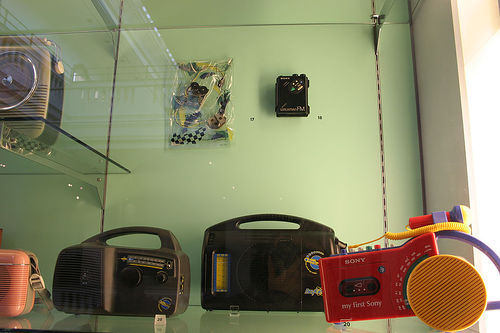

In [ ]:
img = Image.open("imagenette2/train/n02979186/n02979186_11957.JPEG")
img

In [ ]:
# Chunk the dataframe into train and valid dataframes
train_df, valid_df = [i[1] for i in df.groupby('is_valid')]
train_df.to_csv('./imagenette2/train_data.csv', index = False)
valid_df.to_csv('./imagenette2/valid_data.csv', index = False)

In [ ]:
from torchvision.transforms import ToTensor, ToPILImage, CenterCrop

path = Path('./imagenette2')
transform = CenterCrop(size = (256, 256))

class ImagenetDS:

  def __init__(self, df_path = None, df = None):
    self.transform = transform
    self.to_tensor = ToTensor()
    self.path = path

    if not df_path: self.df = df
    else: self.df = pd.read_csv(df_path)

  def __len__(self):
    return len(self.df)

  def get_imt_path(self, idx):
    rec = self.df.iloc[idx]
    path, label = self.path/rec['path'], rec['noisy_labels_0']
    im_t = self.to_tensor(Image.open(path))
    return im_t, rec['path']

  def __getitem__(self, idx):
    im_t, path_str = self.get_imt_path(idx)
    while im_t.shape[0]!= 3:
      idx = idx - 1
      im_t, path_str = self.get_imt_path(idx)

    return (self.transform(im_t), path_str)

In [ ]:
train_ds = ImagenetDS(df = train_df)
valid_ds = ImagenetDS(df = valid_df)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def custom_collate_fn(inp):
  x, y = zip(*inp)
  return torch.stack(x).to(device), y

train_dl, valid_dl = DataLoader(train_ds, 64, True, collate_fn = custom_collate_fn), DataLoader(valid_ds, 64, True, collate_fn = custom_collate_fn)

In [ ]:
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

latent_path = path/'latents'

def store_latents(latents, y):
  for lat, path_suffix in zip(latents, y):
    ps = path_suffix.replace('JPEG', 'pkl')
    p = latent_path/ps
    p.parent.mkdir(parents = True, exist_ok = True)
    torch.save(lat.cpu(), p)

def calculate_nd_store_latents(model, dl):
  for x, y in tqdm(dl):
    with torch.no_grad():
      latents = model.encode(x).latent_dist.mean
    store_latents(latents, y)

In [ ]:
calculate_nd_store_latents(vae, train_dl)

100%|██████████| 148/148 [08:40<00:00,  3.52s/it]


In [ ]:
calculate_nd_store_latents(vae, valid_dl)

100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


In [ ]:
!ls imagenette2/latents/train/n01440764/

ILSVRC2012_val_00000293.pkl  n01440764_13375.pkl  n01440764_29788.pkl  n01440764_6758.pkl
ILSVRC2012_val_00002138.pkl  n01440764_1337.pkl   n01440764_2978.pkl   n01440764_677.pkl
ILSVRC2012_val_00003014.pkl  n01440764_13397.pkl  n01440764_297.pkl    n01440764_6786.pkl
ILSVRC2012_val_00006697.pkl  n01440764_13415.pkl  n01440764_298.pkl    n01440764_6816.pkl
ILSVRC2012_val_00007197.pkl  n01440764_13436.pkl  n01440764_2993.pkl   n01440764_6843.pkl
ILSVRC2012_val_00009346.pkl  n01440764_13464.pkl  n01440764_30045.pkl  n01440764_6878.pkl
ILSVRC2012_val_00009379.pkl  n01440764_13468.pkl  n01440764_30188.pkl  n01440764_6887.pkl
ILSVRC2012_val_00009396.pkl  n01440764_13489.pkl  n01440764_3039.pkl   n01440764_6903.pkl
ILSVRC2012_val_00010306.pkl  n01440764_13495.pkl  n01440764_3048.pkl   n01440764_6917.pkl
ILSVRC2012_val_00011233.pkl  n01440764_13545.pkl  n01440764_30835.pkl  n01440764_6924.pkl
ILSVRC2012_val_00011993.pkl  n01440764_13575.pkl  n01440764_30897.pkl  n01440764_6936.pkl
ILSVRC2012_

In [ ]:
lat = torch.load('imagenette2/latents/train/n01440764/n01440764_10218.pkl')

In [ ]:
lat.shape

torch.Size([4, 32, 32])

<Axes: >

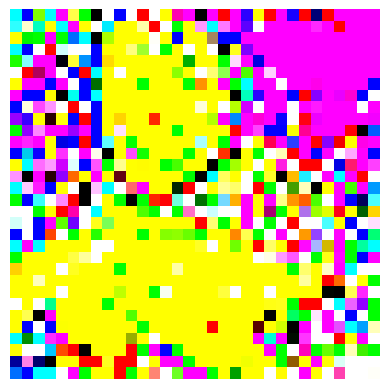

In [ ]:
show_image(lat[:3])

<Axes: >

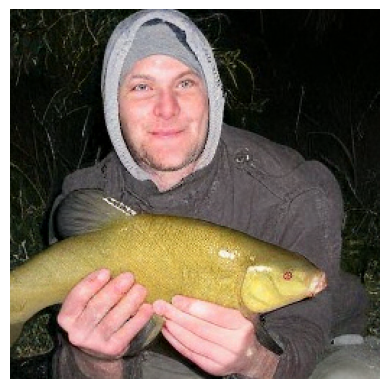

In [ ]:
out = vae.decode(lat[None].cuda())['sample']
show_image(out[0])

In [ ]:
!ls

drive  imagenette2  imagenette2.tgz  sample_data


In [ ]:
!tar -cvzf imagenette2_latents.tgz ./imagenette2

Streaming output truncated to the last 5000 lines.
./imagenette2/latents/train/n03425413/n03425413_16097.pkl
./imagenette2/latents/train/n03425413/n03425413_18357.pkl
./imagenette2/latents/train/n03425413/n03425413_596.pkl
./imagenette2/latents/train/n03425413/n03425413_26127.pkl
./imagenette2/latents/train/n03425413/n03425413_14874.pkl
./imagenette2/latents/train/n03425413/n03425413_14826.pkl
./imagenette2/latents/train/n03425413/n03425413_15647.pkl
./imagenette2/latents/train/n03425413/n03425413_9035.pkl
./imagenette2/latents/train/n03425413/n03425413_21228.pkl
./imagenette2/latents/train/n03425413/n03425413_14409.pkl
./imagenette2/latents/train/n03425413/n03425413_14704.pkl
./imagenette2/latents/train/n03425413/ILSVRC2012_val_00046178.pkl
./imagenette2/latents/train/n03425413/n03425413_1255.pkl
./imagenette2/latents/train/n03425413/n03425413_22034.pkl
./imagenette2/latents/train/n03425413/n03425413_22154.pkl
./imagenette2/latents/train/n03425413/n03425413_10719.pkl
./imagenette2/lat

In [ ]:
!ls

drive  imagenette2  imagenette2_latents.tgz  imagenette2.tgz  sample_data


In [ ]:
!cp imagenette2_latents.tgz /content/drive/MyDrive/fastai_p2/

# Latent Flow Matching on Imagenette2

In [5]:
import pandas as pd
path = Path('./imagenette2')
latent_path = path/'latents'

In [6]:
classes = [i.name for i in (latent_path/'train').ls()]
class_labels = {i: idx for idx, i in enumerate(classes)}

class LatentDS:
  def __init__(self, df):
    self.df = df

  def __len__(self): return len(self.df)

  def get_imt_path(self, idx):
    rec = self.df.iloc[idx]
    local_path_str, label = rec['path'], rec['noisy_labels_0']
    local_path_str = local_path_str.replace('JPEG', 'pkl')
    im_t = torch.load(latent_path/local_path_str)
    return im_t, label

  def __getitem__(self, idx):
    im_t, label = self.get_imt_path(idx)
    return (im_t, class_labels[label])

In [7]:
train_df = pd.read_csv(path/"train_data.csv")
valid_df = pd.read_csv(path/"valid_data.csv")

In [8]:
train_ds = LatentDS(df = train_df)
valid_ds = LatentDS(df = valid_df)

train_dl = DataLoader(train_ds, batch_size = 256, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 256, shuffle = True)

In [9]:
dls = DataLoaders(train_dl, valid_dl)

loss,epoch,train
21.299,0,train
19.593,0,eval


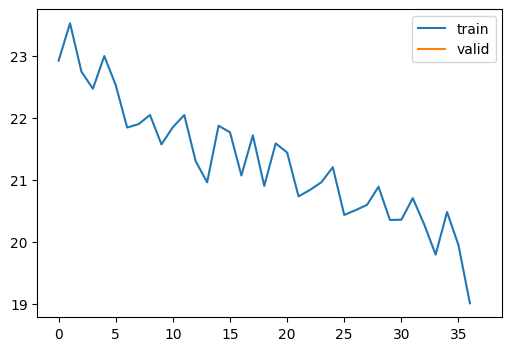

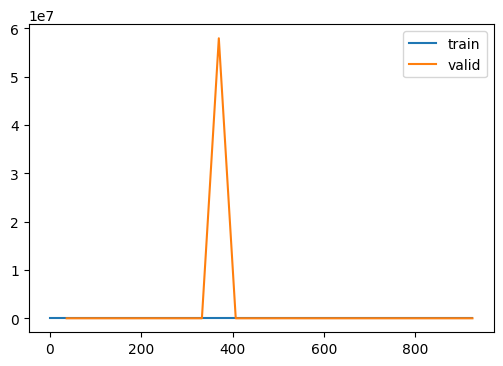

loss,epoch,train
21.299,0,train
19.593,0,eval
18.243,1,train
16.362,1,eval
15.359,2,train
13.676,2,eval
12.970,3,train
8.520,3,eval
10.443,4,train
8.169,4,eval


In [10]:
lr_max, epochs = 4e-04, 25
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          CFM(sigma = 0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(in_channels = 4, out_channels = 4, nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-04))
learner.fit(epochs)

In [13]:
torch.save(learner.model, mdl_path/'latent_flow_matching_imagenet_v1.pkl')

In [14]:
del model
del learner
clean_mem()

loss,epoch,train
3.311,0,train
3.397,0,eval
3.265,1,train
3.250,1,eval
3.311,2,train
3.323,2,eval
3.312,3,train
3.287,3,eval
3.300,4,train
3.323,4,eval


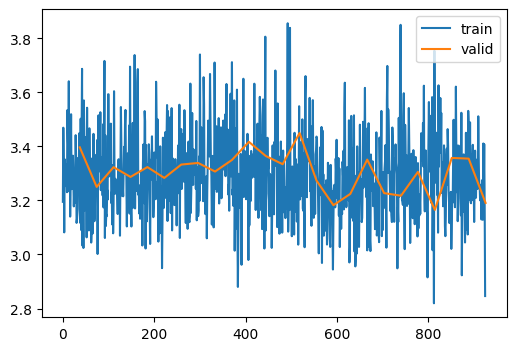

In [16]:
lr_max, epochs = 4e-05, 25
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          CFM(sigma = 0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model = torch.load(mdl_path/'latent_flow_matching_imagenet_v1.pkl')
learner = AccLearner(model, dls, loss_func = combined_loss, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-04))
learner.fit(epochs)

In [19]:
torch.save(learner.model, mdl_path/'latent_flow_matching_imagenet_v2.pkl')

In [22]:
out = sample(model)

In [4]:
vae = None
clean_mem()

In [31]:
torch.save(out, 'generated_latents.pkl')

In [2]:
out = torch.load('generated_latents.pkl')

In [3]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)
images = vae.decode(out[:10])['sample'].cpu()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


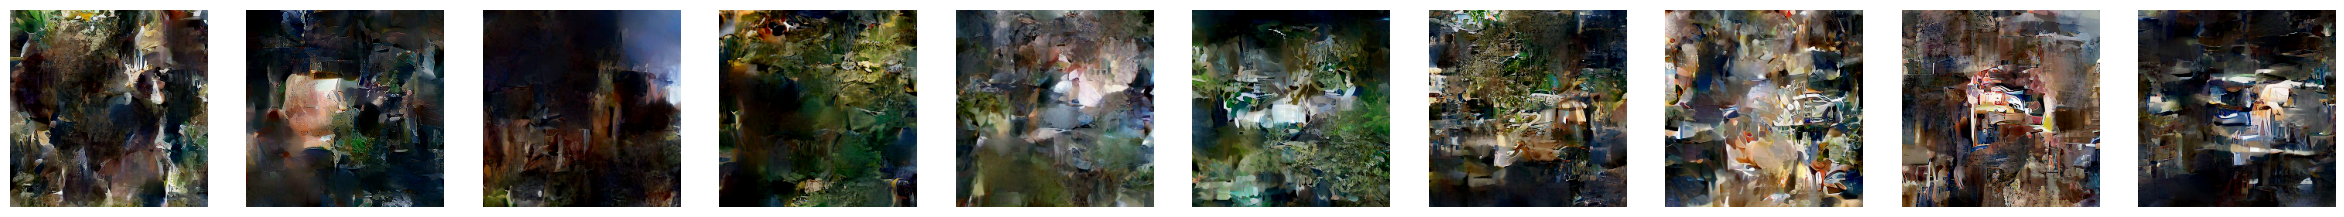

In [4]:
show_images(images, nrows = 1)